In [1]:
from common import *
from experiment import *
from data import DirectRawData, RawData, PlottableData

In [2]:
GROUPS = ['cubic', 'bbr1', 'bbr2', 'bbr3']
TREATMENTS = [
    TCPTreatment(cca='cubic', pep=False, label='tcp_cubic'),
    TCPTreatment(cca='bbr', pep=False, label='tcp_bbr'),
    TCPTreatment(cca='bbr2', pep=False, label='tcp_bbr2'),
    TCPTreatment(cca='bbr', pep=False, label='tcp_bbr1'),  # When the default bbr module on the current Linux kernel is v1!
    TCPTreatment(cca='cubic', pep=True, label='pep_cubic'),
    TCPTreatment(cca='bbr', pep=True, label='pep_bbr'),
    TCPTreatment(cca='bbr2', pep=True, label='pep_bbr2'),
    TCPTreatment(cca='bbr', pep=True, label='pep_bbr1'),  # When the default bbr module on the current Linux kernel is v1!
]
TCP_CUBIC = TREATMENTS[0]
TCP_BBRV3 = TREATMENTS[1]
TCP_BBRV2 = TREATMENTS[2]
TCP_BBRV1 = TREATMENTS[3]
PEP_CUBIC = TREATMENTS[4]
PEP_BBRV3 = TREATMENTS[5]
PEP_BBRV2 = TREATMENTS[6]
PEP_BBRV1 = TREATMENTS[7]

# Pick network settings

In [3]:
# Generate the treatments
treatments_map = {
    'pep': [PEP_CUBIC, PEP_BBRV1, PEP_BBRV2, PEP_BBRV3],
    'tcp': [TCP_CUBIC, TCP_BBRV1, TCP_BBRV2, TCP_BBRV3],
}

In [4]:
# Generate a representative network setting and data size
num_trials = 10
network_settings = [
    NetworkSetting(delay1=1, delay2=80, loss1=0, loss2=4, bw1=10, bw2=50),
    NetworkSetting(delay1=1, delay2=20, loss1=4, loss2=0, bw1=30, bw2=30),
    NetworkSetting(delay1=1, delay2=20, loss1=4, loss2=0, bw1=30, bw2=30).mirror(),
    NetworkSetting(delay1=20, delay2=20, loss1=2, loss2=2, bw1=50, bw2=50),
    NetworkSetting(delay1=1, delay2=20, loss1=3, loss2=1, bw1=30, bw2=30),
]
data_size = lambda bw: int(10*1000000*bw/8)  # 10x the bottleneck bandwidth
data_sizes = [data_size(min(ns.get('bw1'), ns.get('bw2'))) for ns in network_settings]

In [8]:
qdiscs = [
    'red',
    'bfifo-large',
    'bfifo-small',
    'pie',
    'policer',
    # 'codel',
]

# Execute experiments for each qdisc

In [5]:
# TODO: Set the index for the appropriate kernel!
index = 1

In [6]:
def network_settings_with_qdisc(network_settings, qdisc):
    ns_qdiscs = []
    for ns in network_settings:
        ns_qdisc = ns.clone()
        ns_qdisc.set('qdisc', qdisc)
        ns_qdiscs.append(ns_qdisc)
    return ns_qdiscs

def network_setting_with_qdiscs(network_setting, qdiscs):
    ns_qdiscs = []
    for qdisc in qdiscs:
        ns_qdisc = network_setting.clone()
        ns_qdisc.set('qdisc', qdisc)
        ns_qdiscs.append(ns_qdisc)
    return ns_qdiscs

In [7]:
for qdisc in qdiscs:
    # Define the experiment
    exp = Experiment(
        num_trials=1,
        treatments=[
            treatments_map['pep'][index],
            treatments_map['tcp'][index],
        ],
        network_settings=network_settings_with_qdisc(network_settings, qdisc),
        data_sizes=data_sizes,
        cartesian=False,
    )

    # Parse data
    execute = True
    raw_data = RawData(exp, execute=execute)

# Functions to get predicted data

In [9]:
class NetworkModel:
    def __init__(self, delay: int, loss, bw: int):
        self.delay = delay
        self.loss = loss
        self.bw = bw

def compose(s1: NetworkModel, s2: NetworkModel) -> NetworkModel:
    delay = s1.delay + s2.delay
    if s1.delay == 1 or s2.delay == 1:
        delay -= 1
    loss = s1.loss + s2.loss
    bw = min(s1.bw, s2.bw)
    return NetworkModel(delay, loss, bw)

In [10]:
def get_data_size(bottleneck_bw):
    return int(10*1000000*bottleneck_bw/8)  # 10x the bottleneck bandwidth

class TreatmentData:
    def __init__(
        self,
        tcp_treatment: Treatment,
        pep_treatment: Treatment,
        data: PlottableData,
        direct_data: PlottableData,
    ):
        self.tcp = tcp_treatment.label()
        self.pep = pep_treatment.label()
        self.data = data
        self.direct_data = direct_data
    
    def goodput(self, s) -> Optional[float]:
        ns = DirectNetworkSetting(delay=s.delay, loss=s.loss, bw=s.bw)
        data_size = get_data_size(s.bw)
        result = self.direct_data.data[self.tcp][ns.label()].get(data_size)
        if result is None:
            return None
        else:
            return result.p(50)
    
    def pred_split_goodput(self, s1: NetworkModel, s2: NetworkModel) -> Optional[float]:
        goodput1 = self.goodput(s1)
        goodput2 = self.goodput(s2)
        if goodput1 is None or goodput2 is None:
            return None
        return min(goodput1, goodput2)
    
    def pred_e2e_goodput(self, s1: NetworkModel, s2: NetworkModel) -> Optional[float]:
        s = compose(s1, s2)
        return self.goodput(s)
    
    def real_split_goodput(self, ns: NetworkSetting) -> Optional[float]:
        data_size = get_data_size(min(ns.get('bw1'), ns.get('bw2')))
        goodput = self.data.data[self.pep][ns.label()].get(data_size)
        return None if goodput is None else goodput.p(50)
    
    def real_e2e_goodput(self, ns: NetworkSetting) -> Optional[float]:
        data_size = get_data_size(min(ns.get('bw1'), ns.get('bw2')))
        goodput = self.data.data[self.tcp][ns.label()].get(data_size)
        return None if goodput is None else goodput.p(50)

In [11]:
def _tuple_list_to_ordered_set(tuple_list):
    arr = list(chain.from_iterable(tuple_list))
    arr = list(set(arr))
    arr.sort()
    return arr

def gen_direct_data(treatments, bw_splits, delay_splits, loss_splits, timeout=180, execute=False, num_trials=1):
    exp = Experiment(
        num_trials, treatments, [], [],
        network_losses=_tuple_list_to_ordered_set(loss_splits),
        network_delays=_tuple_list_to_ordered_set(delay_splits),
        network_bws=_tuple_list_to_ordered_set(bw_splits),
        timeout=timeout,
        cartesian=False,
    )
    raw_data = DirectRawData(exp, execute=execute)
    plottable_data = PlottableData(raw_data, metric='throughput_mbps')
    return plottable_data
    
def gen_data(treatments, network_settings, timeout=None, execute=False, num_trials=1):
    network_settings = list(chain.from_iterable(network_settings))
    data_sizes = [get_data_size(min(ns.get('bw1'), ns.get('bw2'))) for ns in network_settings]
    exp = Experiment(
        num_trials, treatments, network_settings, data_sizes,
        timeout=timeout,
        cartesian=False,
    )
    raw_data = RawData(exp, execute=execute)
    plottable_data = PlottableData(raw_data, metric='throughput_mbps')
    return plottable_data

In [12]:
def gen_x_labels_with_loss(bw_splits, delay_splits):
    labels = []
    for bw1, bw2 in bw_splits:
        for delay1, delay2 in delay_splits:
            label = f'{bw1}_{bw2}_{delay1}_{delay2}'
            labels.append(label)
    return labels

def gen_network_settings_with_loss(bw_splits, delay_splits, loss_splits):
    network_settings = []
    for loss1, loss2 in loss_splits:
        nses = []
        for bw1, bw2 in bw_splits:
            for delay1, delay2 in delay_splits:
                ns = NetworkSetting(delay1=delay1, delay2=delay2, bw1=bw1, bw2=bw2, loss1=loss1, loss2=loss2)
                nses.append(ns)
        network_settings.append(nses)
    return network_settings

In [23]:
from itertools import chain

def gen_treatment_data(tcp_treatment, pep_treatment, execute=False):
    # Define parameters
    delay_splits = [(1, 80), (40, 40), (80, 1)]
    bw_splits = [(10, 50), (10, 10), (50, 10)]
    loss_splits = [(4, 0), (3, 1), (2, 2), (1, 3), (0, 4)]
    network_settings = gen_network_settings_with_loss(bw_splits, delay_splits, loss_splits)
    
    # Generate data
    data = gen_data([tcp_treatment, pep_treatment], network_settings, timeout=180, execute=execute, num_trials=num_trials)
    direct_data = gen_direct_data([tcp_treatment], bw_splits=bw_splits, delay_splits=delay_splits, loss_splits=loss_splits, timeout=None, execute=False, num_trials=num_trials)
    treatment_data = TreatmentData(tcp_treatment, pep_treatment, data=data, direct_data=direct_data)
    return treatment_data

# Plotting function

In [14]:
def compare_qdiscs(data, qdiscs, ns_qdiscs, data_size, group, network_setting, delta=25, ylabel='Goodput (Mbit/s)', predict=None):
    treatments = data.treatments

    # Bar width and positions
    if predict is None:
        num_bars = len(qdiscs)
    else:
        s1 = NetworkModel(delay=network_setting.get('delay1'), bw=network_setting.get('bw1'), loss=network_setting.get('loss1'))
        s2 = NetworkModel(delay=network_setting.get('delay2'), bw=network_setting.get('bw2'), loss=network_setting.get('loss2'))
        pred_e2e = predict.pred_e2e_goodput(s1, s2)
        pred_split = predict.pred_split_goodput(s1, s2)
        print('pred_e2e', pred_e2e)
        print('pred_split', pred_split)
        if pred_e2e is None:
            pred_e2e = 0
        if pred_split is None:
            pred_split = 0
        num_bars = 1 + len(qdiscs)
    bar_width = 1 / num_bars - 0.01
    x = np.arange(len(treatments))

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Add bars for predicted data
    if predict is not None:
        ys = []
        for treatment in treatments:
            if 'pep' in treatment:
                ys.append(pred_split)
            else:
                ys.append(pred_e2e)
        ax.bar(x - bar_width/2, ys, bar_width, label='predicted')

    # Add bars for each qdisc
    for i, (qdisc, ns) in enumerate(zip(qdiscs, ns_qdiscs)):
        ys = []
        yerr_lower = []
        yerr_upper = []

        for treatment in treatments:
            subdata = data.data[treatment][ns.label()].get(data_size)
            if subdata is None:
                ys.append(0)
                yerr_lower.append(0)
                yerr_upper.append(0)
                continue
            ys.append(subdata.p(50))
            yerr_lower.append(subdata.p(50) - subdata.p(50-delta))
            yerr_upper.append(subdata.p(50+delta) - subdata.p(50))

        if predict is None:
            bar_x = x - bar_width/2 + i*bar_width
        else:
            bar_x = x - bar_width/2 + (i+1)*bar_width
        ax.bar(bar_x, ys, bar_width, yerr=(yerr_lower, yerr_upper), label=qdisc)
        
    # Labeling and formatting
    ax.set_xlabel('Congestion Control Algorithm')
    ax.set_ylabel(ylabel)
    ax.set_title(f'{group} {network_setting.label()}')
    ax.set_xticks(x)
    ax.set_xticklabels(treatments)
    ax.grid()
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=num_bars)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot data

MISSING: sudo -E python3 emulation/main.py --bw1 10 --bw2 50 --delay2 80 --loss1 0 --loss2 4 --qdisc red -t 5 --label pep_cubic tcp --pep -cca cubic -n 12500000
MISSING: sudo -E python3 emulation/main.py --bw1 10 --bw2 50 --delay2 80 --loss1 0 --loss2 4 --qdisc bfifo-large -t 5 --label pep_cubic tcp --pep -cca cubic -n 12500000
MISSING: sudo -E python3 emulation/main.py --bw1 10 --bw2 50 --delay2 80 --loss1 0 --loss2 4 --qdisc bfifo-small -t 5 --label pep_cubic tcp --pep -cca cubic -n 12500000
MISSING: sudo -E python3 emulation/main.py --bw1 10 --bw2 50 --delay2 80 --loss1 0 --loss2 4 --qdisc pie -t 9 --label pep_cubic tcp --pep -cca cubic -n 12500000
MISSING: sudo -E python3 emulation/main.py --bw1 10 --bw2 50 --delay2 80 --loss1 0 --loss2 4 --qdisc policer -t 9 --label pep_cubic tcp --pep -cca cubic -n 12500000


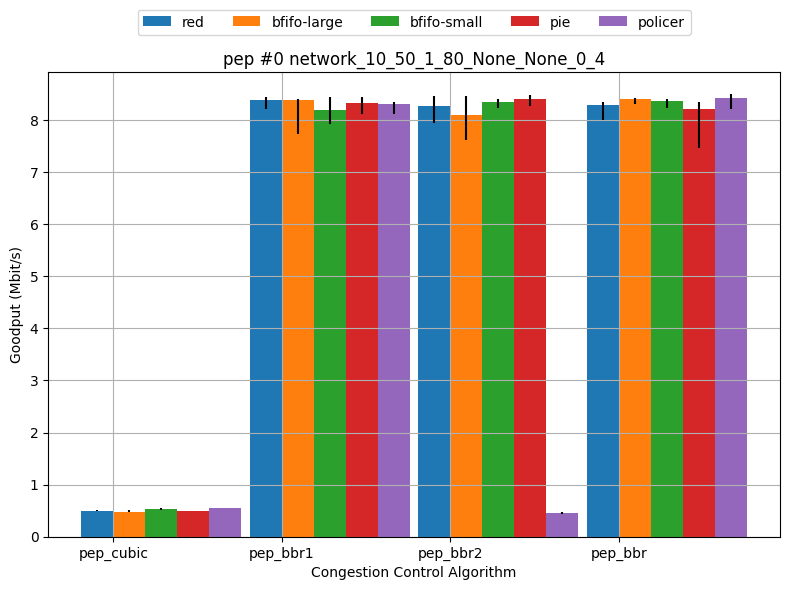

MISSING: sudo -E python3 emulation/main.py --bw1 10 --bw2 50 --delay2 80 --loss1 0 --loss2 4 --qdisc red -t 5 --label tcp_cubic tcp -cca cubic -n 12500000
MISSING: sudo -E python3 emulation/main.py --bw1 10 --bw2 50 --delay2 80 --loss1 0 --loss2 4 --qdisc bfifo-large -t 5 --label tcp_cubic tcp -cca cubic -n 12500000
MISSING: sudo -E python3 emulation/main.py --bw1 10 --bw2 50 --delay2 80 --loss1 0 --loss2 4 --qdisc bfifo-small -t 9 --label tcp_cubic tcp -cca cubic -n 12500000
MISSING: sudo -E python3 emulation/main.py --bw1 10 --bw2 50 --delay2 80 --loss1 0 --loss2 4 --qdisc pie -t 9 --label tcp_cubic tcp -cca cubic -n 12500000
MISSING: sudo -E python3 emulation/main.py --bw1 10 --bw2 50 --delay2 80 --loss1 0 --loss2 4 --qdisc policer -t 9 --label tcp_cubic tcp -cca cubic -n 12500000
MISSING: sudo -E python3 emulation/main.py --bw1 10 --bw2 50 --delay2 80 --loss1 0 --loss2 4 --qdisc policer -t 5 --label tcp_bbr2 tcp -cca bbr2 -n 12500000


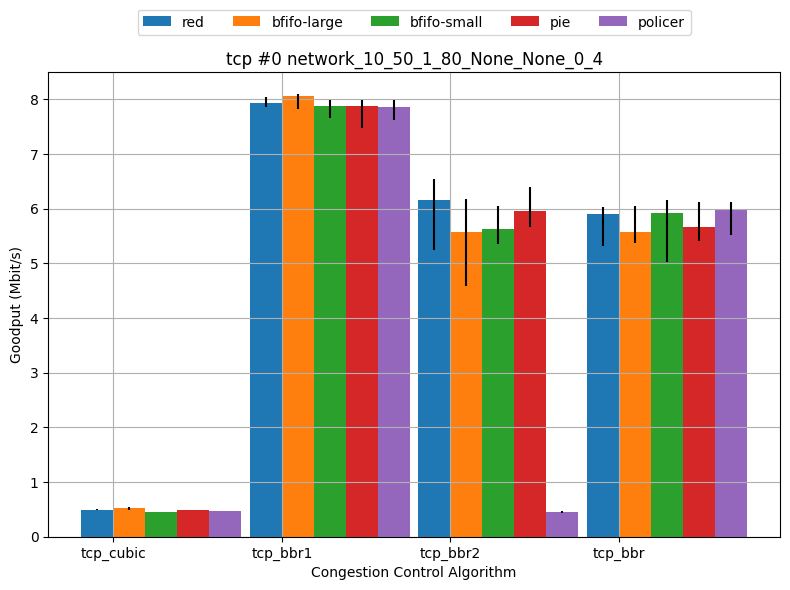

MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc red -t 9 --label pep_cubic tcp --pep -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc bfifo-large -t 10 --label pep_cubic tcp --pep -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc bfifo-small -t 10 --label pep_cubic tcp --pep -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc pie -t 10 --label pep_cubic tcp --pep -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc policer -t 10 --label pep_cubic tcp --pep -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc red -t 9 --label pep_bbr1 tcp --pep -cca bbr -n 37500000
MISSING: sudo

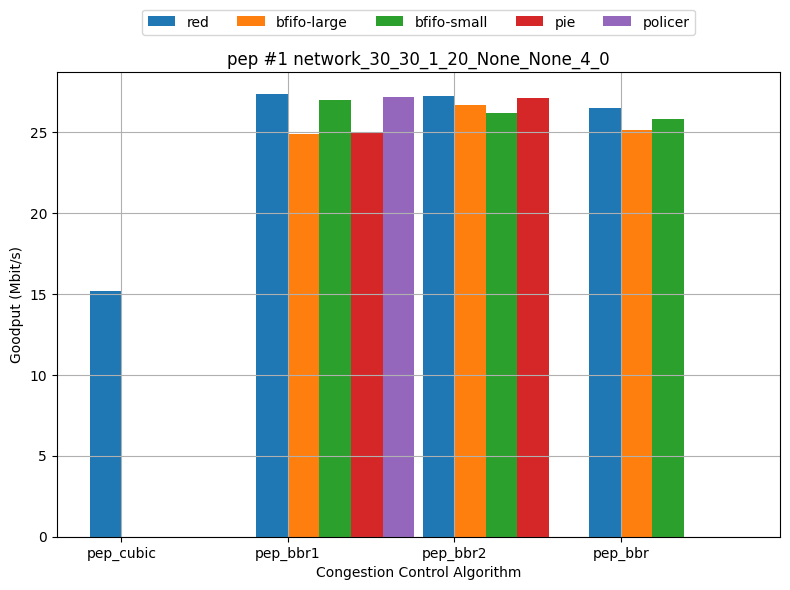

MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc red -t 10 --label tcp_cubic tcp -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc bfifo-large -t 10 --label tcp_cubic tcp -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc bfifo-small -t 10 --label tcp_cubic tcp -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc pie -t 10 --label tcp_cubic tcp -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc policer -t 10 --label tcp_cubic tcp -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc red -t 9 --label tcp_bbr1 tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1

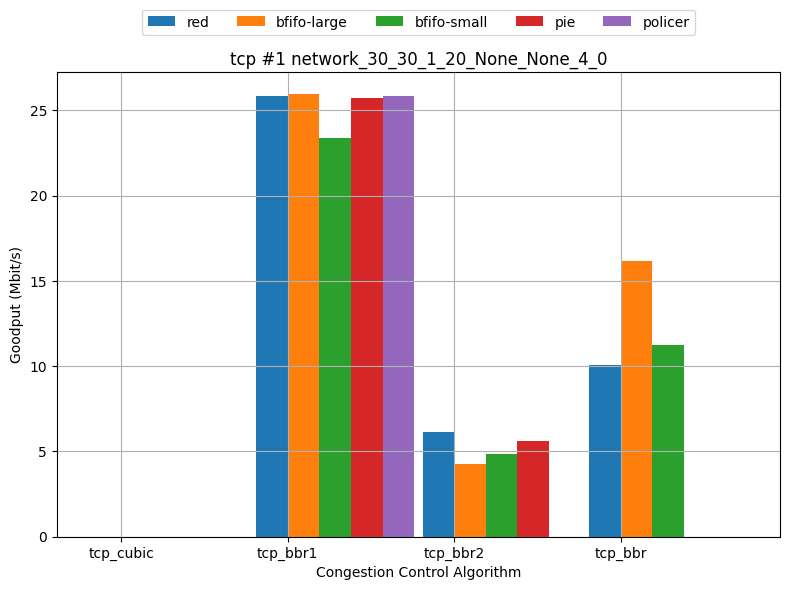

MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc red -t 9 --label pep_cubic tcp --pep -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc bfifo-large -t 10 --label pep_cubic tcp --pep -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc bfifo-small -t 10 --label pep_cubic tcp --pep -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc pie -t 10 --label pep_cubic tcp --pep -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc policer -t 10 --label pep_cubic tcp --pep -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc red 

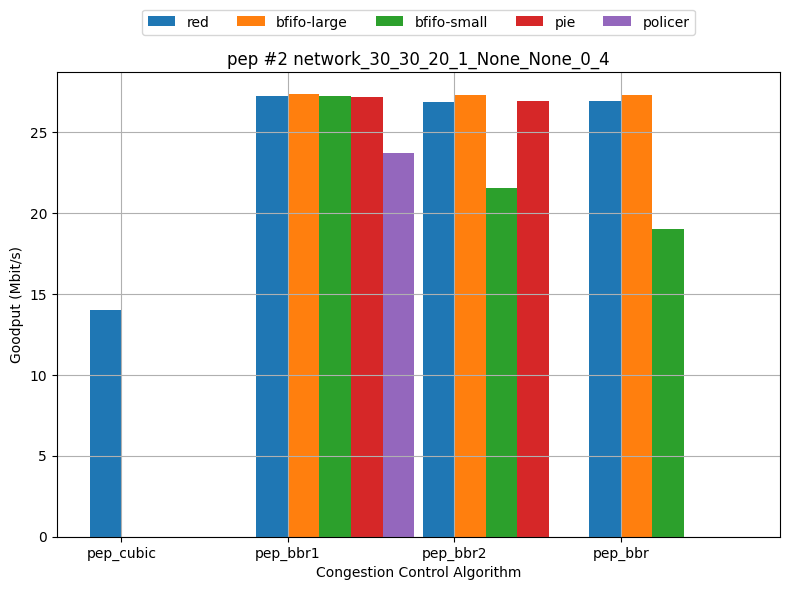

MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc red -t 10 --label tcp_cubic tcp -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc bfifo-large -t 10 --label tcp_cubic tcp -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc bfifo-small -t 10 --label tcp_cubic tcp -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc pie -t 10 --label tcp_cubic tcp -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc policer -t 10 --label tcp_cubic tcp -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc red -t 9 --label tcp_bbr1 tcp -cc

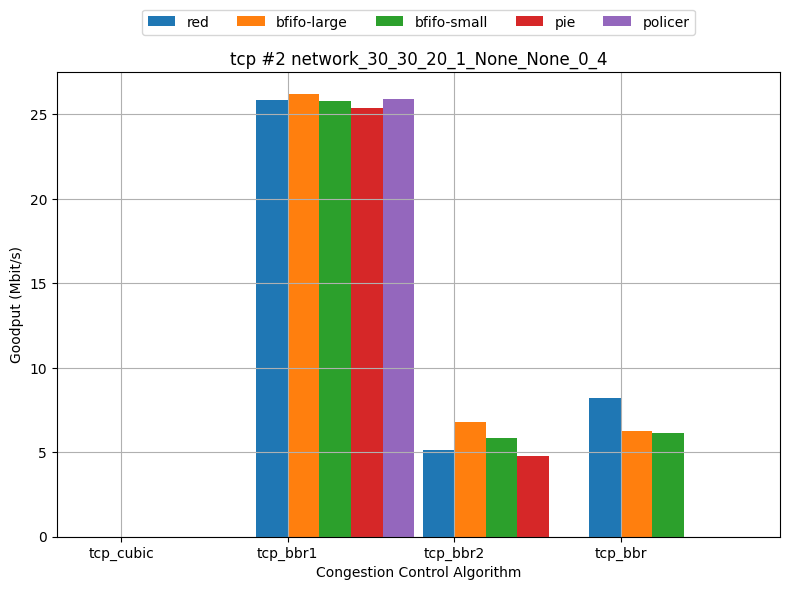

MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc red -t 9 --label pep_cubic tcp --pep -cca cubic -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc bfifo-large -t 10 --label pep_cubic tcp --pep -cca cubic -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc bfifo-small -t 10 --label pep_cubic tcp --pep -cca cubic -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc pie -t 10 --label pep_cubic tcp --pep -cca cubic -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc policer -t 10 --label pep_cubic tcp --pep -cca cubic -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdis

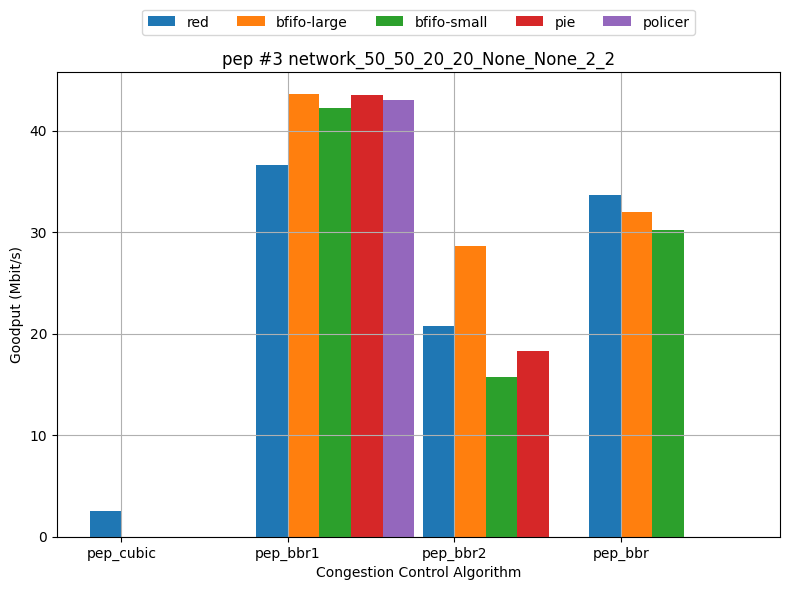

MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc red -t 10 --label tcp_cubic tcp -cca cubic -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc bfifo-large -t 10 --label tcp_cubic tcp -cca cubic -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc bfifo-small -t 10 --label tcp_cubic tcp -cca cubic -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc pie -t 10 --label tcp_cubic tcp -cca cubic -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc policer -t 10 --label tcp_cubic tcp -cca cubic -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc red -t 9 --label tcp_bbr1 t

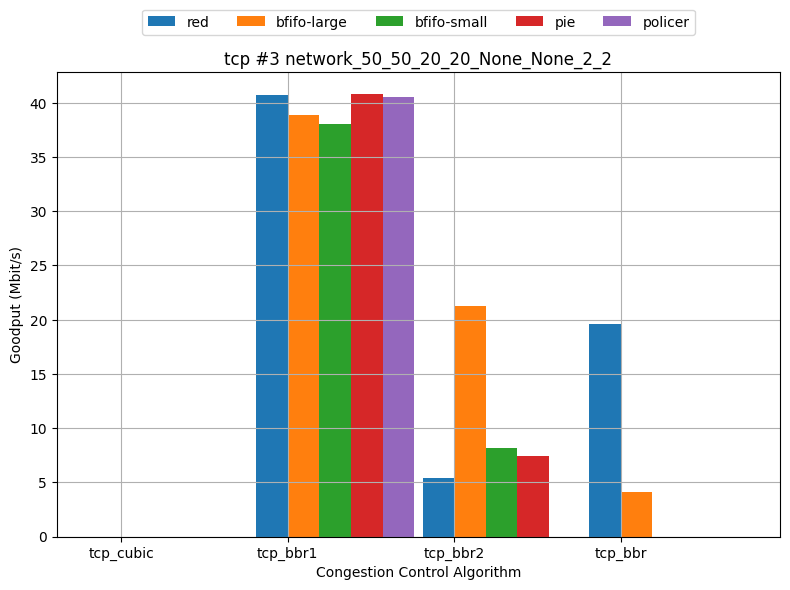

MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc red -t 9 --label pep_cubic tcp --pep -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc bfifo-large -t 10 --label pep_cubic tcp --pep -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc bfifo-small -t 10 --label pep_cubic tcp --pep -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc pie -t 10 --label pep_cubic tcp --pep -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc policer -t 10 --label pep_cubic tcp --pep -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc red -t 9 --label pep_bbr1 tcp --pep -cca bbr -n 37500000
MISSING: sudo

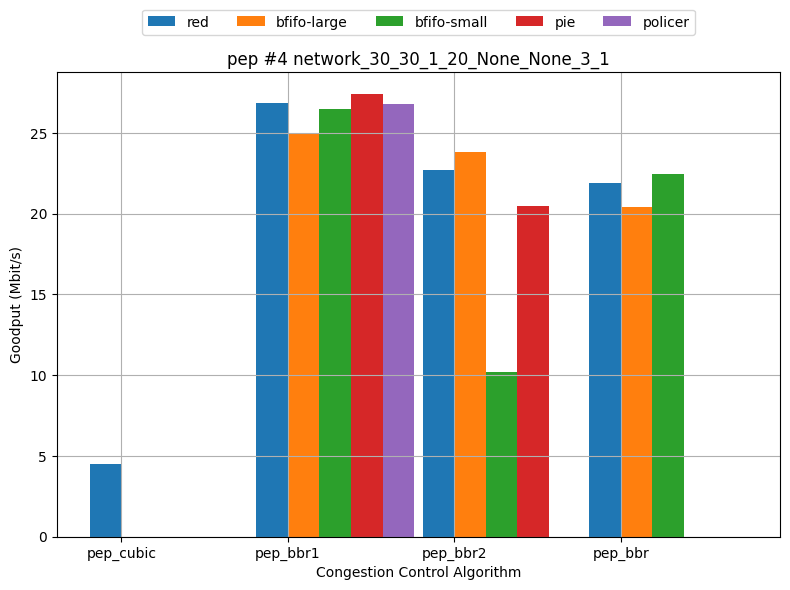

MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc red -t 10 --label tcp_cubic tcp -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc bfifo-large -t 10 --label tcp_cubic tcp -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc bfifo-small -t 10 --label tcp_cubic tcp -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc pie -t 10 --label tcp_cubic tcp -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc policer -t 10 --label tcp_cubic tcp -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc red -t 9 --label tcp_bbr1 tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1

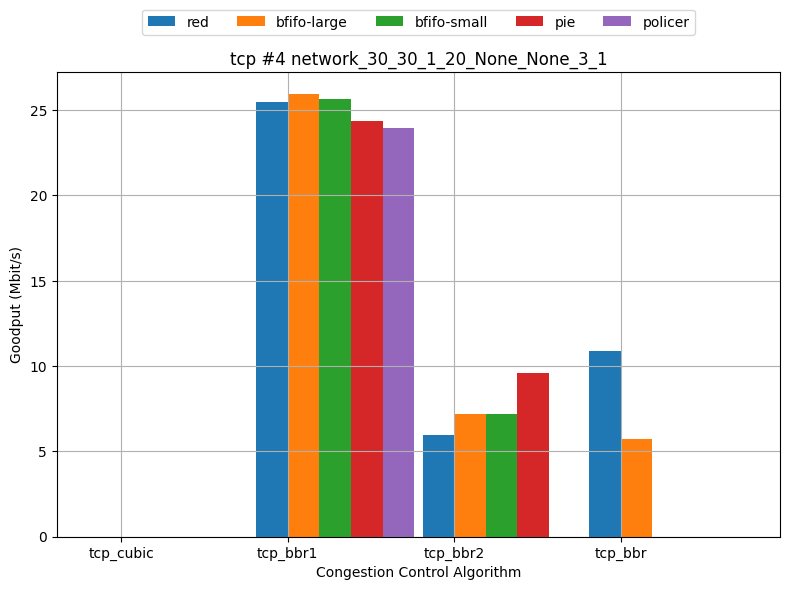

In [15]:
for ns_index, (network_setting, data_size) in enumerate(zip(network_settings, data_sizes)):
    ns_qdiscs = network_setting_with_qdiscs(network_setting, qdiscs)
    for group, treatments in treatments_map.items():
        # Define the experiment
        exp = Experiment(
            num_trials=10,
            treatments=treatments,
            network_settings = ns_qdiscs,
            data_sizes = [data_size],
        )

        # Parse data
        raw_data = RawData(exp, execute=False)
        
        # Convert to plottable data
        metric = 'throughput_mbps'
        plottable_data = PlottableData(raw_data, metric=metric)
        compare_qdiscs(plottable_data, qdiscs, ns_qdiscs, data_size, f'{group} #{ns_index}', network_setting)

# Plot by CCA

In [20]:
def plot_by_cca(tcp_treatment, pep_treatment, network_settings, data_sizes, num_trials=10, qdiscs=qdiscs):
    treatment_data = gen_treatment_data(tcp_treatment, pep_treatment)
    for ns_index, (network_setting, data_size) in enumerate(zip(network_settings, data_sizes)):
        ns_qdiscs = network_setting_with_qdiscs(network_setting, qdiscs)
        # Define the experiment
        exp = Experiment(
            num_trials=num_trials,
            treatments=[tcp_treatment, pep_treatment],
            network_settings = ns_qdiscs,
            data_sizes = [data_size],
        )
    
        # Parse data
        raw_data = RawData(exp, execute=False)
        
        # Convert to plottable data
        metric = 'throughput_mbps'
        plottable_data = PlottableData(raw_data, metric=metric)
        compare_qdiscs(plottable_data, qdiscs, ns_qdiscs, data_size, '', network_setting, predict=treatment_data)

MISSING: sudo -E python3 emulation/main.py --bw1 50 --delay1 80 --loss1 3 --topology direct -t 1 --label tcp_bbr tcp -cca bbr -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --delay1 80 --loss1 4 --topology direct -t 7 --label tcp_bbr tcp -cca bbr -n 62500000
pred_e2e 6.182530057213955
pred_split 9.51115415782023


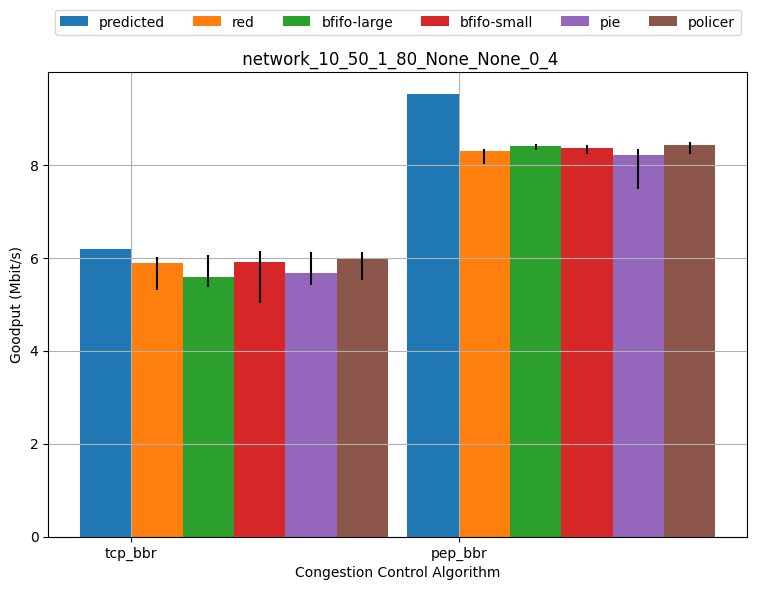

MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc red -t 9 --label tcp_bbr tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc bfifo-large -t 9 --label tcp_bbr tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc bfifo-small -t 9 --label tcp_bbr tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc pie -t 10 --label tcp_bbr tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc policer -t 10 --label tcp_bbr tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc red -t 9 --label pep_bbr tcp --pep -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --del

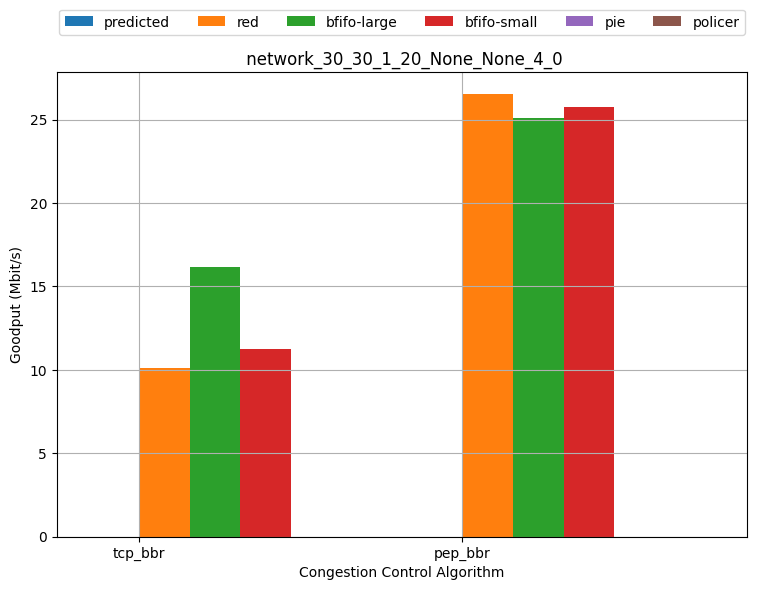

MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc red -t 9 --label tcp_bbr tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc bfifo-large -t 9 --label tcp_bbr tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc bfifo-small -t 9 --label tcp_bbr tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc pie -t 10 --label tcp_bbr tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc policer -t 10 --label tcp_bbr tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc red -t 9 --label pep_bbr tcp --pep -cca bbr -n 37500000


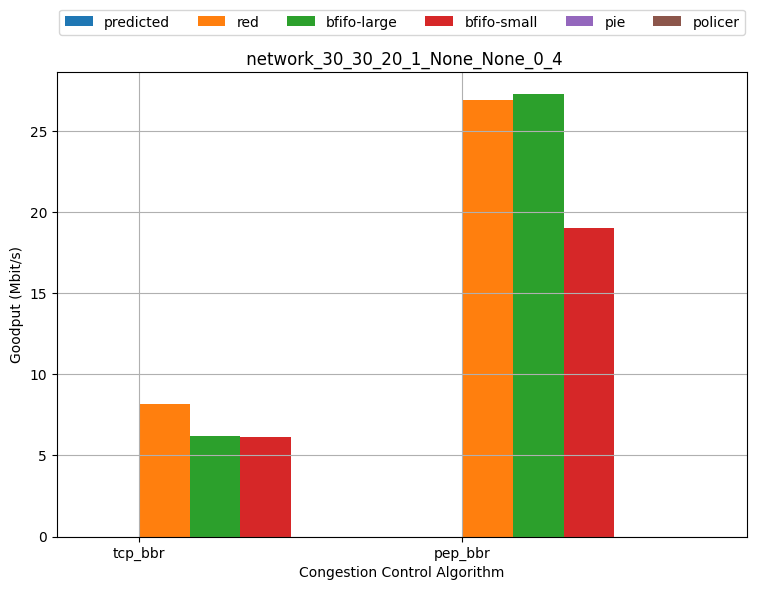

MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc red -t 9 --label tcp_bbr tcp -cca bbr -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc bfifo-large -t 9 --label tcp_bbr tcp -cca bbr -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc bfifo-small -t 10 --label tcp_bbr tcp -cca bbr -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc pie -t 10 --label tcp_bbr tcp -cca bbr -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc policer -t 10 --label tcp_bbr tcp -cca bbr -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc red -t 9 --label pep_bbr tcp --pep -cca bbr -n 62

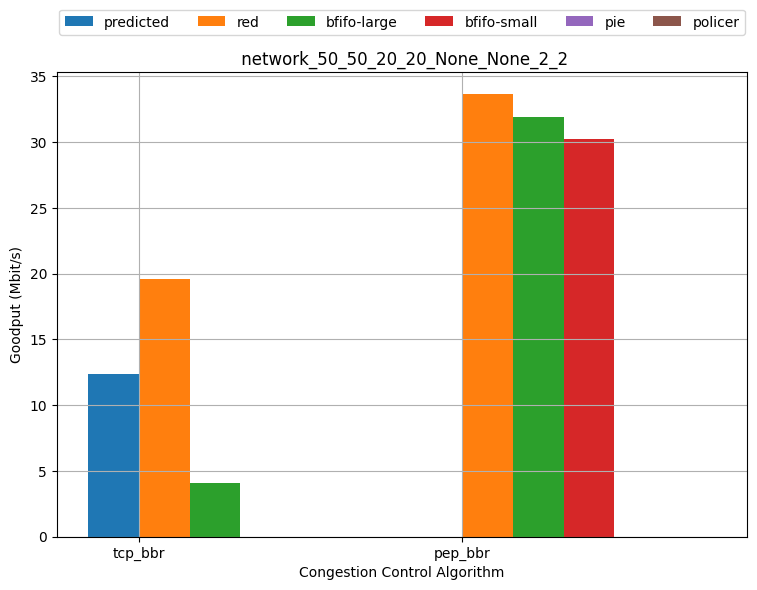

MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc red -t 9 --label tcp_bbr tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc bfifo-large -t 9 --label tcp_bbr tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc bfifo-small -t 10 --label tcp_bbr tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc pie -t 10 --label tcp_bbr tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc policer -t 10 --label tcp_bbr tcp -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc red -t 9 --label pep_bbr tcp --pep -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --de

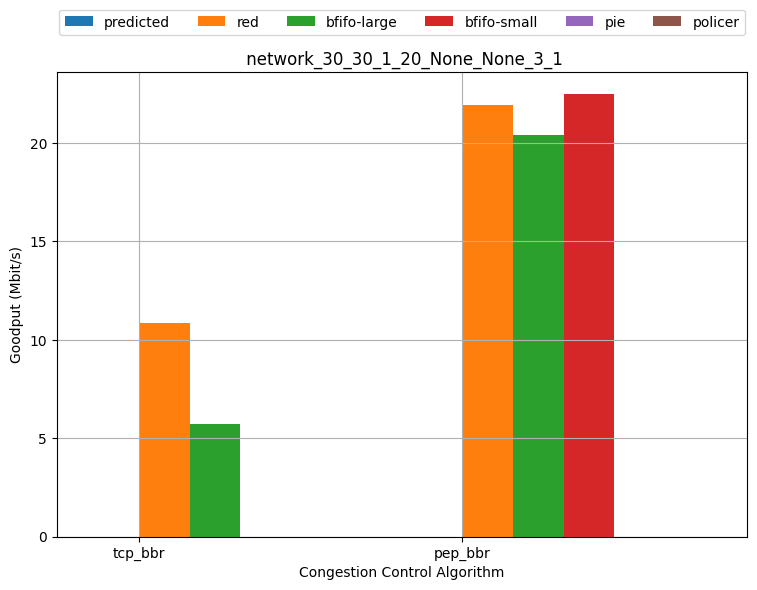

In [19]:
plot_by_cca(TCP_BBRV3, PEP_BBRV3, network_settings, data_sizes, num_trials=10)

MISSING: sudo -E python3 emulation/main.py --bw1 50 --delay1 80 --loss1 4 --topology direct -t 5 --label tcp_bbr2 tcp -cca bbr2 -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 10 --bw2 50 --delay2 80 --loss1 0 --loss2 4 --qdisc policer -t 5 --label tcp_bbr2 tcp -cca bbr2 -n 12500000
pred_e2e 5.282499918322693
pred_split 9.504476494419213


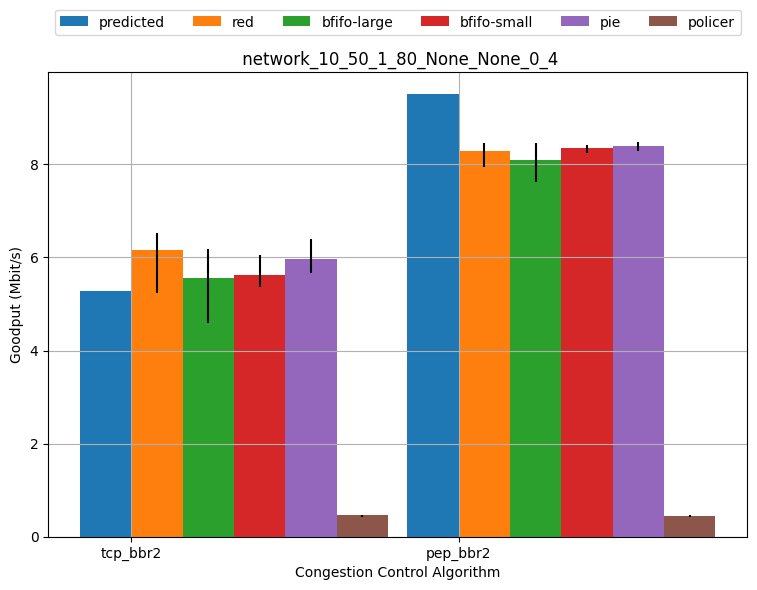

MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc red -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc bfifo-large -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc bfifo-small -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc pie -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc policer -t 10 --label tcp_bbr2 tcp -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 --loss2 0 --qdisc red -t 9 --label pep_bbr2 tcp --pep -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --b

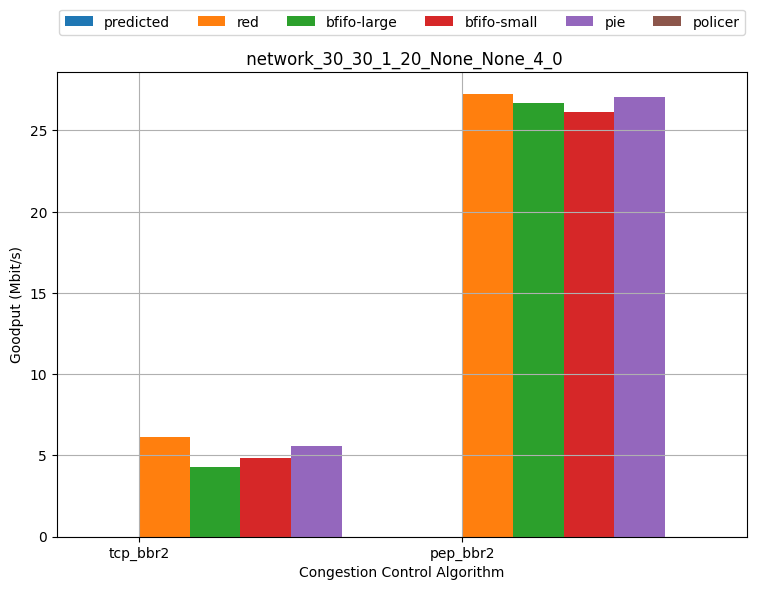

MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc red -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc bfifo-large -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc bfifo-small -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc pie -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc policer -t 10 --label tcp_bbr2 tcp -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 --qdisc red -t 9 --label pep_bbr2 tcp --pep -cca bbr2 -

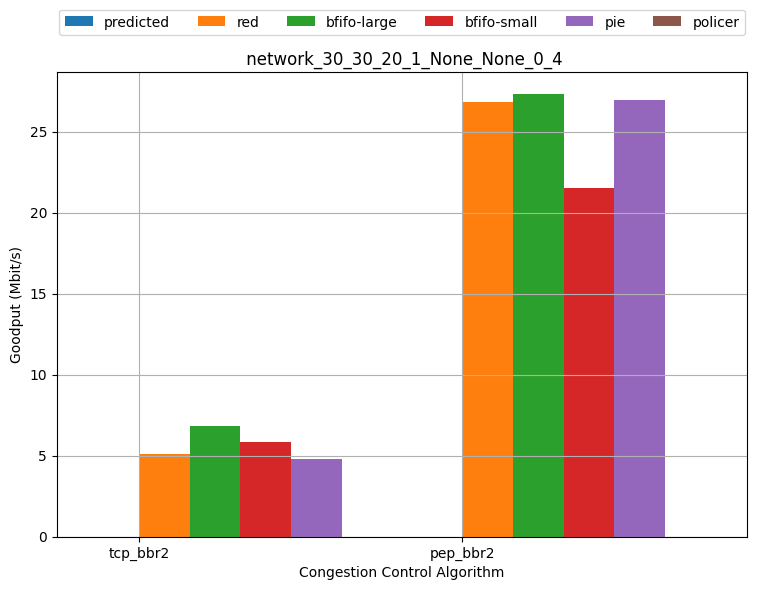

MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc red -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc bfifo-large -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc bfifo-small -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc pie -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc policer -t 10 --label tcp_bbr2 tcp -cca bbr2 -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --bw2 50 --delay1 20 --delay2 20 --loss1 2 --loss2 2 --qdisc red -t 9 --label pep_bbr2 tcp --pep -cca 

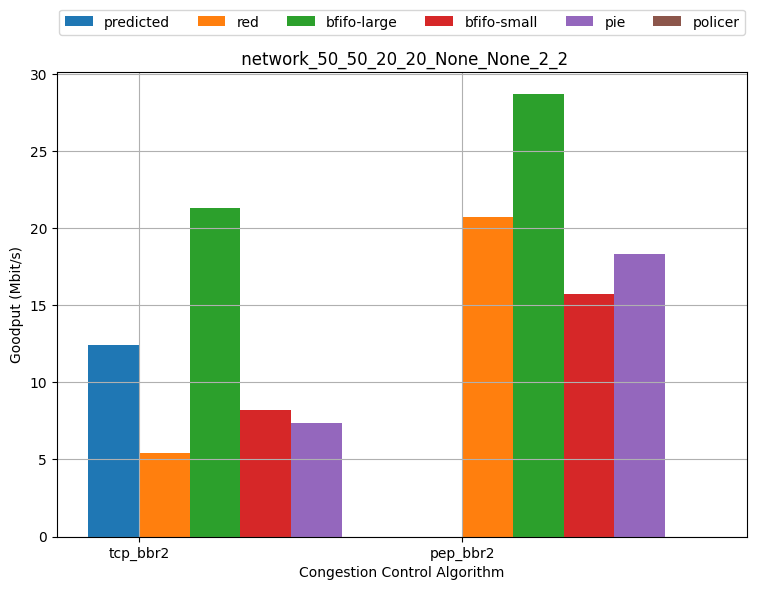

MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc red -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc bfifo-large -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc bfifo-small -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc pie -t 9 --label tcp_bbr2 tcp -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc policer -t 10 --label tcp_bbr2 tcp -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 3 --loss2 1 --qdisc red -t 9 --label pep_bbr2 tcp --pep -cca bbr2 -n 37500000
MISSING: sudo -E python3 emulation/main.py --bw1 30 --b

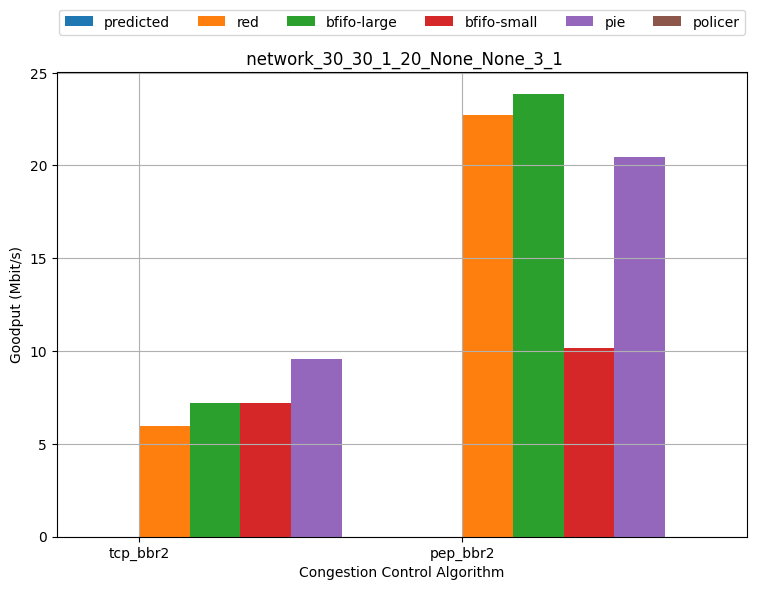

In [21]:
plot_by_cca(TCP_BBRV2, PEP_BBRV2, network_settings, data_sizes, num_trials=10)

In [22]:
plot_by_cca(TCP_BBRV1, PEP_BBRV1, network_settings, data_sizes, num_trials=10)

45
sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --bw2 50 --delay2 80 --loss1 4 --loss2 0 -t 9 --label tcp_bbr1 tcp -cca bbr -n 12500000 

KeyboardInterrupt: 

In [ ]:
plot_by_cca(TCP_CUBIC, PEP_CUBIC, network_settings, data_sizes, num_trials=10)